In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "intestine_intestine_Chen2019"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.txt"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation


ERROR: Error in data[[rlabp]]: subscript out of bounds


In [4]:
data.metadata <- read.table(file = paste0(datasetName,"_metadata.txt"), h = T, sep = "\t", row.names = 1)

In [5]:
ncol(data.matrix)

[1] 14537

Warning message in CreateSeuratObject(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


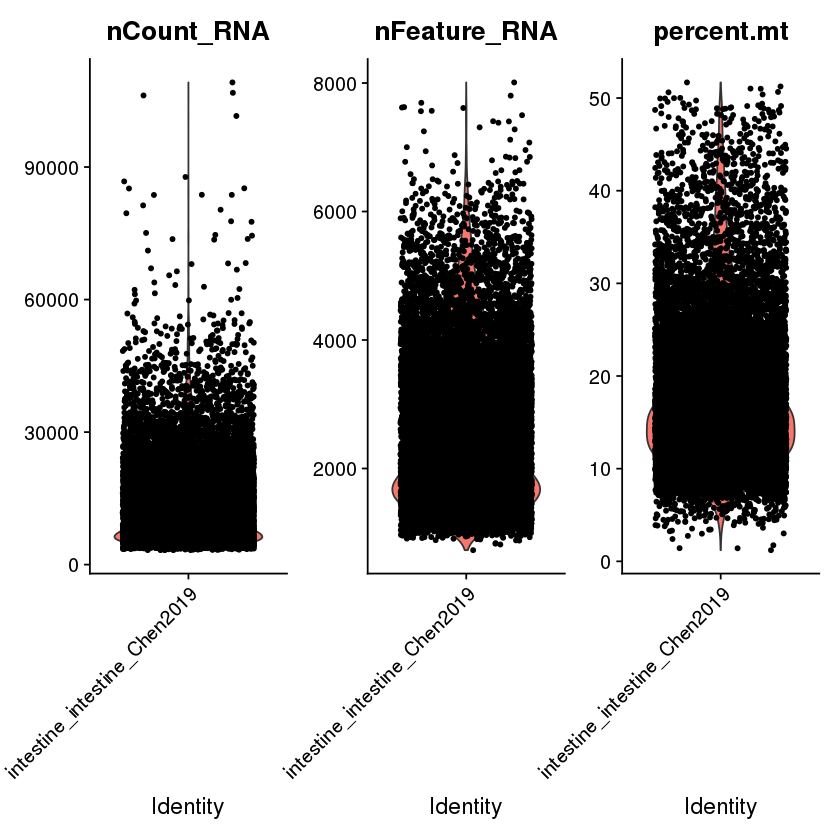

In [8]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [10]:
percent.mt.thre = 40
dataobj <- subset(dataobj, percent.mt < percent.mt.thre)

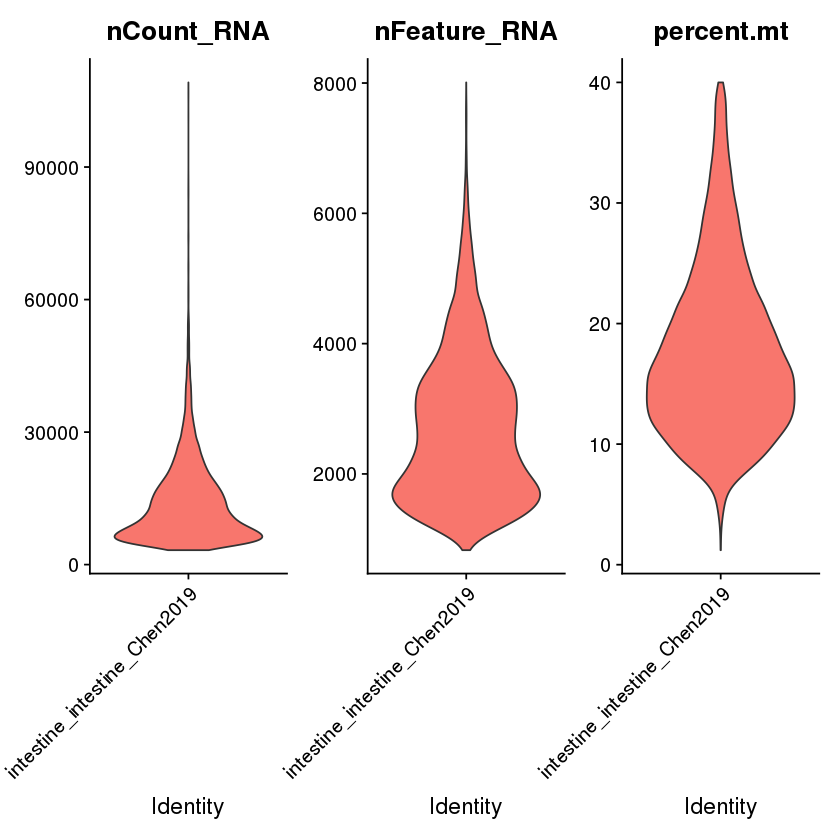

In [11]:
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"), pt.size=0)

In [7]:
head(dataobj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,percent.mt
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<int>,<lgl>,<dbl>
AAACCTGCAAGGACTG.S66,colon_colon_Kinchen2018,2775.124,2313,Colon,Colon,NA,normal,S66,Male,55,NA,1.477396
AAACCTGCACAACTGT.S66,colon_colon_Kinchen2018,2151.229,1133,Colon,Colon,NA,normal,S66,Male,55,NA,1.914844
AAACCTGCACCCTATC.S66,colon_colon_Kinchen2018,2298.313,1449,Colon,Colon,NA,normal,S66,Male,55,NA,2.092093
AAACCTGCAGGCTCAC.S66,colon_colon_Kinchen2018,2119.602,1272,Colon,Colon,NA,normal,S66,Male,55,NA,1.958543
AAACCTGCAGTCTTCC.S66,colon_colon_Kinchen2018,2584.286,1873,Colon,Colon,NA,normal,S66,Male,55,NA,1.781820
AAACCTGGTCATACTG.S66,colon_colon_Kinchen2018,2573.748,1581,Colon,Colon,NA,normal,S66,Male,55,NA,1.794376


In [12]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [13]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 19525 14215
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "RP11-34P13.7"  "FO538757.2"    "AP006222.2"    "RP4-669L17.10"
[5] "RP11-206L10.9"
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 15911 14215
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878 14215
[1] "Finished"


In [15]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  RPS6, MARCKSL1, RPSA, GPX2, RPL37A, RPLP1, RPL4, RPS2, RPS18, RPS3 
	   RPS16, PTMA, RPS8, RPL39, RPL32, RPS17, RPL10A, AGR2, PPP1R1B, RPL31 
	   RPL6, RPS7, RPL23, RPS24, STARD10, RPL22, RPS21, RPS13, CD24, RPS3A 
Negative:  ALDOB, PRAP1, DPEP1, SMIM24, IL32, CDHR5, SELENOP, ADIRF, ANPEP, GUCA2A 
	   RIMBP2, HLA-DRA, KHK, FABP2, APOB, ACE, FABP6, HLA-DRB1, CYP3A4, APOA1 
	   APOC3, SLC7A9, PHGR1, SERPINA1, C3orf85, CD74, APOA4, SGK1, GSTA1, REEP6 
PC_ 2 
Positive:  RPS19, RPL3, RPL18A, PEBP1, RPS18, RPLP0, RPS15A, RPS3A, RPL26, RPL32 
	   SPINK1, RPS24, RPS5, RPLP1, RPL7, RPS8, RPL5, RPS21, RPS2, RPS3 
	   RPL10A, RPL39, OLFM4, RPS17, RPS13, HNRNPA1, RPL31, RPS4X, RPL22, RPL17 
Negative:  CEACAM7, MS4A12, CEACAM6, CEACAM5, CD177, TSPAN1, LYPD8, FXYD3, LGALS13, PARM1 
	   CA4, CEACAM1, CKB, GSN, SCNN1B, MUC12, CA2, AQP8, SLC26A2, SLC26A3 
	   DHRS9, CA1, GPA33, CLCA4, TFF1, MUC13, UGP2, SCNN1A, BCAS1, SH3BGRL3 
PC_ 3 
Positive:  TFF3, FCGBP, REP15, LRRC26, CLCA1, KLK1

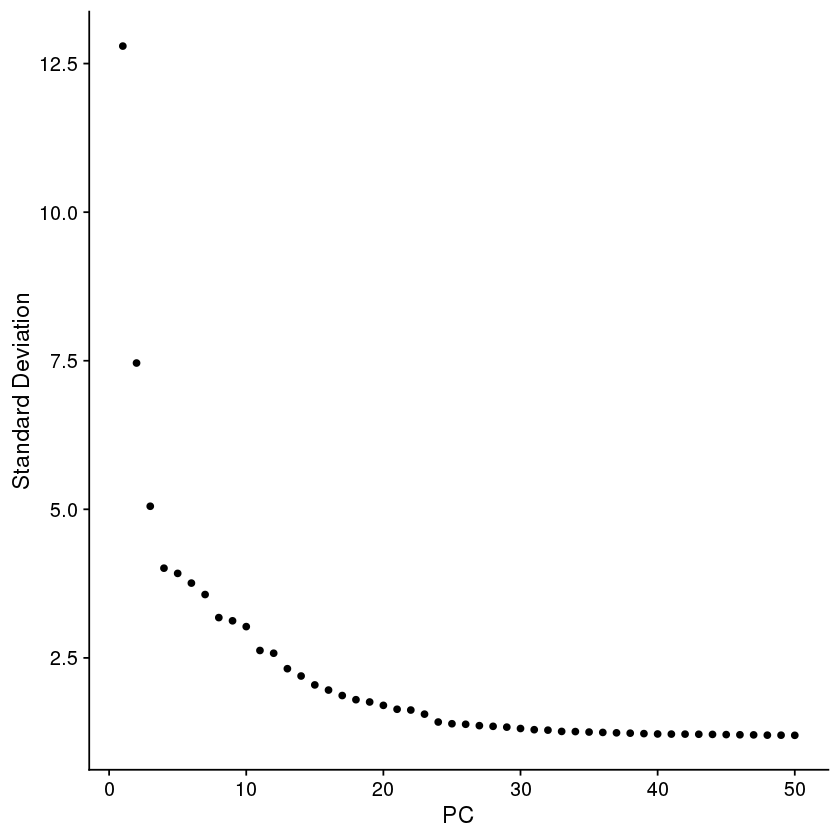

In [16]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
ElbowPlot(dataobj,ndim=50) 

In [17]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [52]:
rownames(data.metadata)<- colnames(data.matrix)

In [71]:
dataobj <- FindClusters(dataobj, resolution = 0.1, n.start = 5)
randIndex(dataobj$CellType,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14215
Number of edges: 542165

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.9764
Number of communities: 10
Elapsed time: 1 seconds


ARI 
0.2445415

In [33]:
dataobj$CellType<-as.factor(dataobj$CellType)

In [37]:
rownames(data.metadata) <- sub("Stem Cell","Stem.Cell",rownames(data.metadata))

In [53]:
dataobj <- AddMetaData(dataobj,data.metadata)

In [19]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:52:18 UMAP embedding parameters a = 0.9922 b = 1.112

21:52:18 Read 14215 rows and found 30 numeric columns

21:52:18 Using Annoy for neighbor search, n_neighbors = 30

21:52:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:52:22 Writing NN index file to temp file /tmp/Rtmp3U2fiu/file7e454399327b

21:52:22 Searching Annoy index using 1 thread, search_k = 3000

21:52:27 Annoy recall = 100%

21:52:28 Commencing smooth kNN distance calibration using 1 thread

21:52:29 Initializing f

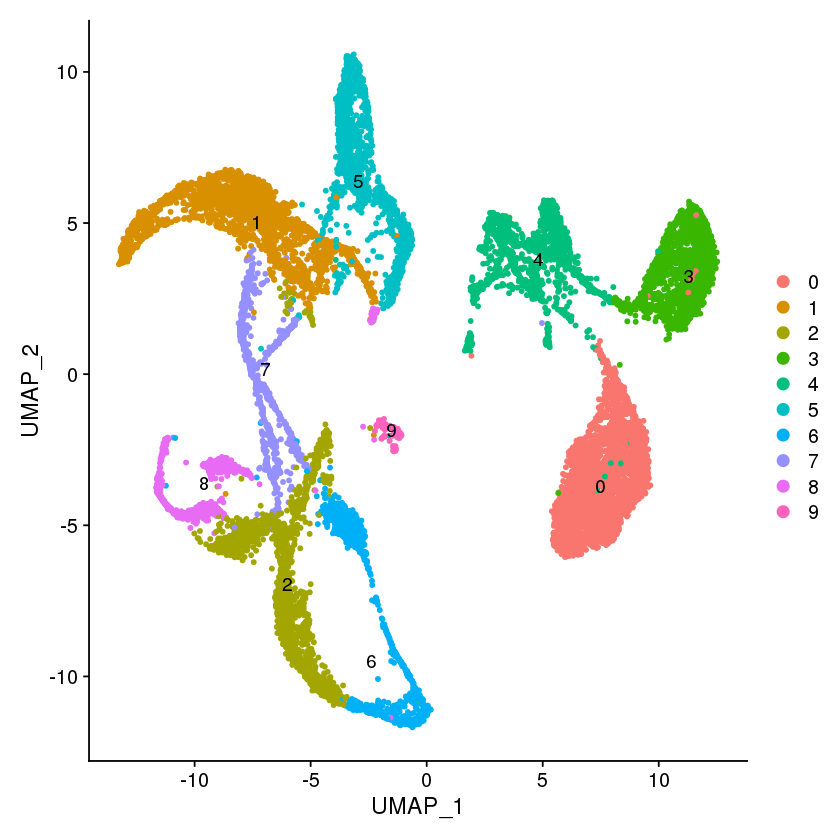

In [56]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
p_umap

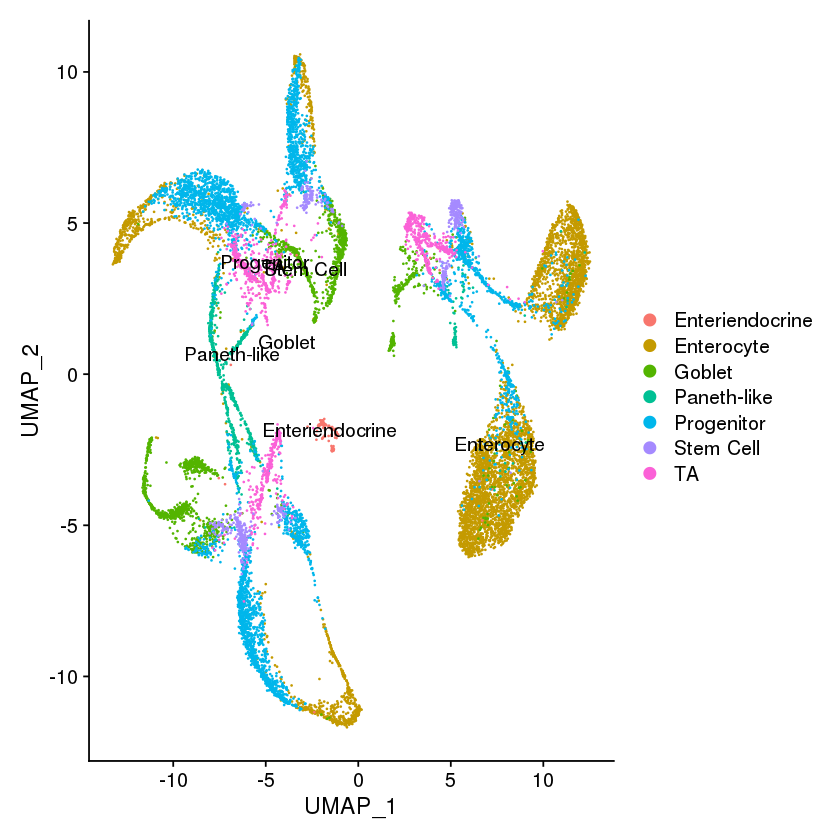

In [57]:
DimPlot(dataobj,label = TRUE,group.by = 'CellType')

In [77]:
new.cluster.ids <- c("Intestine-Epithelial tissue-Enterocyte-APOA1",
                     "Intestine-Epithelial tissue-Enterocyte Progenitor-GPX2",
                     "Unclassified",
                     "Intestine-Epithelial tissue-Enterocyte-CYBRD1",
                     "Intestine-Nerve tissue-Schwann cell-STMN1", 
                     "Intestine-Epithelial tissue-Enterocyte Progenitor-GPX2",
                     "Intestine-Connective tissue-B cell-IGKC",
                     "Intestine-Epithelial tissue-Paneth cell-LYZ",
                     "Intestine-Epithelial tissue-Goblet cell-TFF3",
                     "Intestine-Epithelial tissue-Enteroendocrine cell-CHGB")

In [76]:
subset(dataobj.markers,cluster=='10')
# subset(dataobj.markers,gene=='C1QA')

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>


In [78]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [79]:
annodataobj <- RunUMAP(annodataobj,dims=1:pcDim)

22:46:31 UMAP embedding parameters a = 0.9922 b = 1.112

22:46:31 Read 14215 rows and found 30 numeric columns

22:46:31 Using Annoy for neighbor search, n_neighbors = 30

22:46:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

22:46:36 Writing NN index file to temp file /tmp/Rtmp3U2fiu/file7e452cf977f3

22:46:36 Searching Annoy index using 1 thread, search_k = 3000

22:46:41 Annoy recall = 100%

22:46:41 Commencing smooth kNN distance calibration using 1 thread

22:46:43 Initializing from normalized Laplacian + noise

22:46:43 Commencing optimization for 200 epochs, with 591240 positive edges

22:47:04 Optimization finished



In [ ]:
p_umap4 <- UMAPPlot(annodataobj,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
p_umap4

In [58]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [81]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [84]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1084/jem.20191130"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Intestine"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"10X"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$Sample_ID
dataobj.dbupload_v1$donor_gender<-'NA'
dataobj.dbupload_v1$donor_age<- 'NA'
dataobj.dbupload_v1$original_name<-dataobj$CellType
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [85]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)

In [ ]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [86]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subgion"       "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [3]:
dataobj.dbupload_v1 <- readRDS(paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [11]:
unique(dataobj.dbupload_v1$organ)

[1] "Intestine"

In [15]:
dataobj.dbupload_v1$donor_age<- sub("55","55yr",dataobj.dbupload_v1$donor_age)
dataobj.dbupload_v1$donor_age<- sub("65","65yr",dataobj.dbupload_v1$donor_age)

In [4]:
colnames(dataobj.dbupload_v1@meta.data)[6] <- 'subregion'

In [27]:
library(stringr)
unlist(strsplit('Intestine-Epithelial tissue-Enterocyte-CYBRD1','-'))[2]

[1] "Epithelial tissue"

In [31]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 14215 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [ ]:
lapply(lapply(dataobj.dbupload_v1@meta.data$hcad_name,function(x) split(x,1)),function(x) split(x,1))

In [28]:
dataobj.dbupload_v1@meta.data$tissue_type <- lapply(dataobj.dbupload_v1@meta.data$hcad_name,function(x) unlist(strsplit(x,'-'))[2])
dataobj.dbupload_v1@meta.data$cell_type <- lapply(dataobj.dbupload_v1@meta.data$hcad_name,function(x) unlist(strsplit(x,'-'))[3])
dataobj.dbupload_v1@meta.data$marker_gene <- lapply(dataobj.dbupload_v1@meta.data$hcad_name,function(x) unlist(strsplit(x,'-'))[4])
dataobj.dbupload_v1@meta.data$tissue_type <- as.character(dataobj.dbupload_v1@meta.data$tissue_type)
dataobj.dbupload_v1@meta.data$cell_type <- as.character(dataobj.dbupload_v1@meta.data$cell_type)
dataobj.dbupload_v1@meta.data$marker_gene <- as.character(dataobj.dbupload_v1@meta.data$marker_gene)

In [6]:
dataobj.dbupload_v1$hcad_name<- sub("Enterocyte Progenitor","Enterocyte progenitor",dataobj.dbupload_v1$hcad_name)

In [4]:
dataobj.dbupload_v1$cell_type<- sub("Enterocyte Progenitor","Enterocyte progenitor",dataobj.dbupload_v1$cell_type)

In [30]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [3]:
name = 'intestine_intestine_Chen2019'
path <- paste0("/stor/public/hcad/db_v1/",name,"/",name,".seuratobj.dbupload_v1.rds")
dataobj <- readRDS(path)

In [4]:
unique(dataobj$hcad_name)

[1] "Intestine-Epithelial tissue-Enterocyte-CYBRD1"         
[2] "Intestine-Epithelial tissue-Enterocyte-APOA1"          
[3] "Intestine-Nerve tissue-Schwann cell-STMN1"             
[4] "Unclassified"                                          
[5] "Intestine-Epithelial tissue-Enterocyte progenitor-GPX2"
[6] "Intestine-Epithelial tissue-Paneth cell-LYZ"           
[7] "Intestine-Epithelial tissue-Goblet cell-TFF3"          
[8] "Intestine-Connective tissue-B cell-IGKC"               
[9] "Intestine-Epithelial tissue-Enteroendocrine cell-CHGB"